In [12]:
# Import required packages for presentation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
sys.path.append('/disks/data/PhD/Inferences/PLI')

# PyGeoInf imports
from pygeoinf.interval.function_providers import BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.functions import Function
from pygeoinf.linear_solvers import CholeskySolver, LUSolver, GMRESMatrixSolver
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator, SOLAOperator
from pygeoinf.forward_problem import LinearForwardProblem

# Presentation styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

warnings.filterwarnings('ignore', category=UserWarning)

# Create output directory for presentation figures
presentation_dir = 'conference_presentation_sola_figures'
if not os.path.exists(presentation_dir):
    os.makedirs(presentation_dir)

print("🎯 Conference Presentation: SOLA Method")
print("=" * 60)
print("📁 Figures will be saved to:", presentation_dir)

🎯 Conference Presentation: SOLA Method
📁 Figures will be saved to: conference_presentation_sola_figures


### The Model Space $\mathcal{M}$

We work in $L^2([0,6371])$ with:
- **Basis**: Sine functions for smooth representation
- **Prior covariance**: $C_0 = (-\alpha \Delta)^{-1}$ (inverse scaled Laplacian)
- **Boundary conditions**: Dirichlet (zero at boundaries)
- **Smoothness parameter**: $\alpha$ controls correlation length

This choice promotes smooth solutions while allowing flexibility for data fitting.

In [10]:
# Problem setup parameters
DOMAIN = IntervalDomain(0, 6371)
N_BASIS = 25       # High resolution for smooth representations
ALPHA = 1e-4       # Smoothness parameter for prior
RANDOM_SEED = 42   # Reproducibility
N_DATA = 50        # Number of data points
N_PROPERTIES = 5   # Number of target properties

# Create model space
M = L2Space(N_BASIS, DOMAIN, basis_type='sine')
print(f"📐 Model space: L²([0,6371]) with {N_BASIS} sine basis functions")

# Define prior covariance operator: (-α∆)^{-1}
bc_dirichlet = BoundaryConditions(bc_type='dirichlet', left=0, right=0)
C_0 = LaplacianInverseOperator(M, bc_dirichlet, alpha=ALPHA)

# Prior mean function (promoting expected structure)
def prior_mean_function(x):
    """Prior mean promoting smooth, physically reasonable models"""
    return 0.3 * np.sin(np.pi * x / DOMAIN.length) + 0.1 * (x / DOMAIN.length)

m_0 = Function(M, evaluate_callable=prior_mean_function)

# Create Gaussian measure on model space
K_KL = 100  # Karhunen-Loève expansion terms
M.create_gaussian_measure(method='kl', kl_expansion=K_KL, covariance=C_0, expectation=m_0)

print(f"✓ Prior covariance: (-{ALPHA}∆)⁻¹ with Dirichlet boundary conditions")
print(f"✓ Prior mean: Smooth function promoting physical structure")
print(f"✓ Karhunen-Loève expansion: {K_KL} terms")

# Get eigenvalue information for analysis
eigenvals = C_0.get_all_eigenvalues(min(50, N_BASIS))
print(f"📊 Eigenvalue decay: {eigenvals[0]:.2e} to {eigenvals[-1]:.2e}")
print(f"📊 Condition number: {eigenvals[0]/eigenvals[-1]:.1e}")

📐 Model space: L²([0,6371]) with 25 sine basis functions
Setting up GeneralFEMSolver with 100 basis functions from BasisProvider
Using analytical stiffness matrix computation for hat functions
LaplacianInverseOperator initialized with hat function FEM solver, dirichlet(left=0, right=0) BCs
✓ Prior covariance: (-0.0001∆)⁻¹ with Dirichlet boundary conditions
✓ Prior mean: Smooth function promoting physical structure
✓ Karhunen-Loève expansion: 100 terms
📊 Eigenvalue decay: 4.11e+02 to 6.58e-01
📊 Condition number: 6.2e+02


### Model Prior Visualization

The prior encodes our beliefs about the model before seeing data. This visualization shows:
- **Prior mean**: Expected model structure
- **Prior samples**: Range of possible models under the prior
- **Uncertainty bands**: Point-wise variability

🎨 Generating prior samples for visualization...
📊 Computing prior uncertainty bounds...


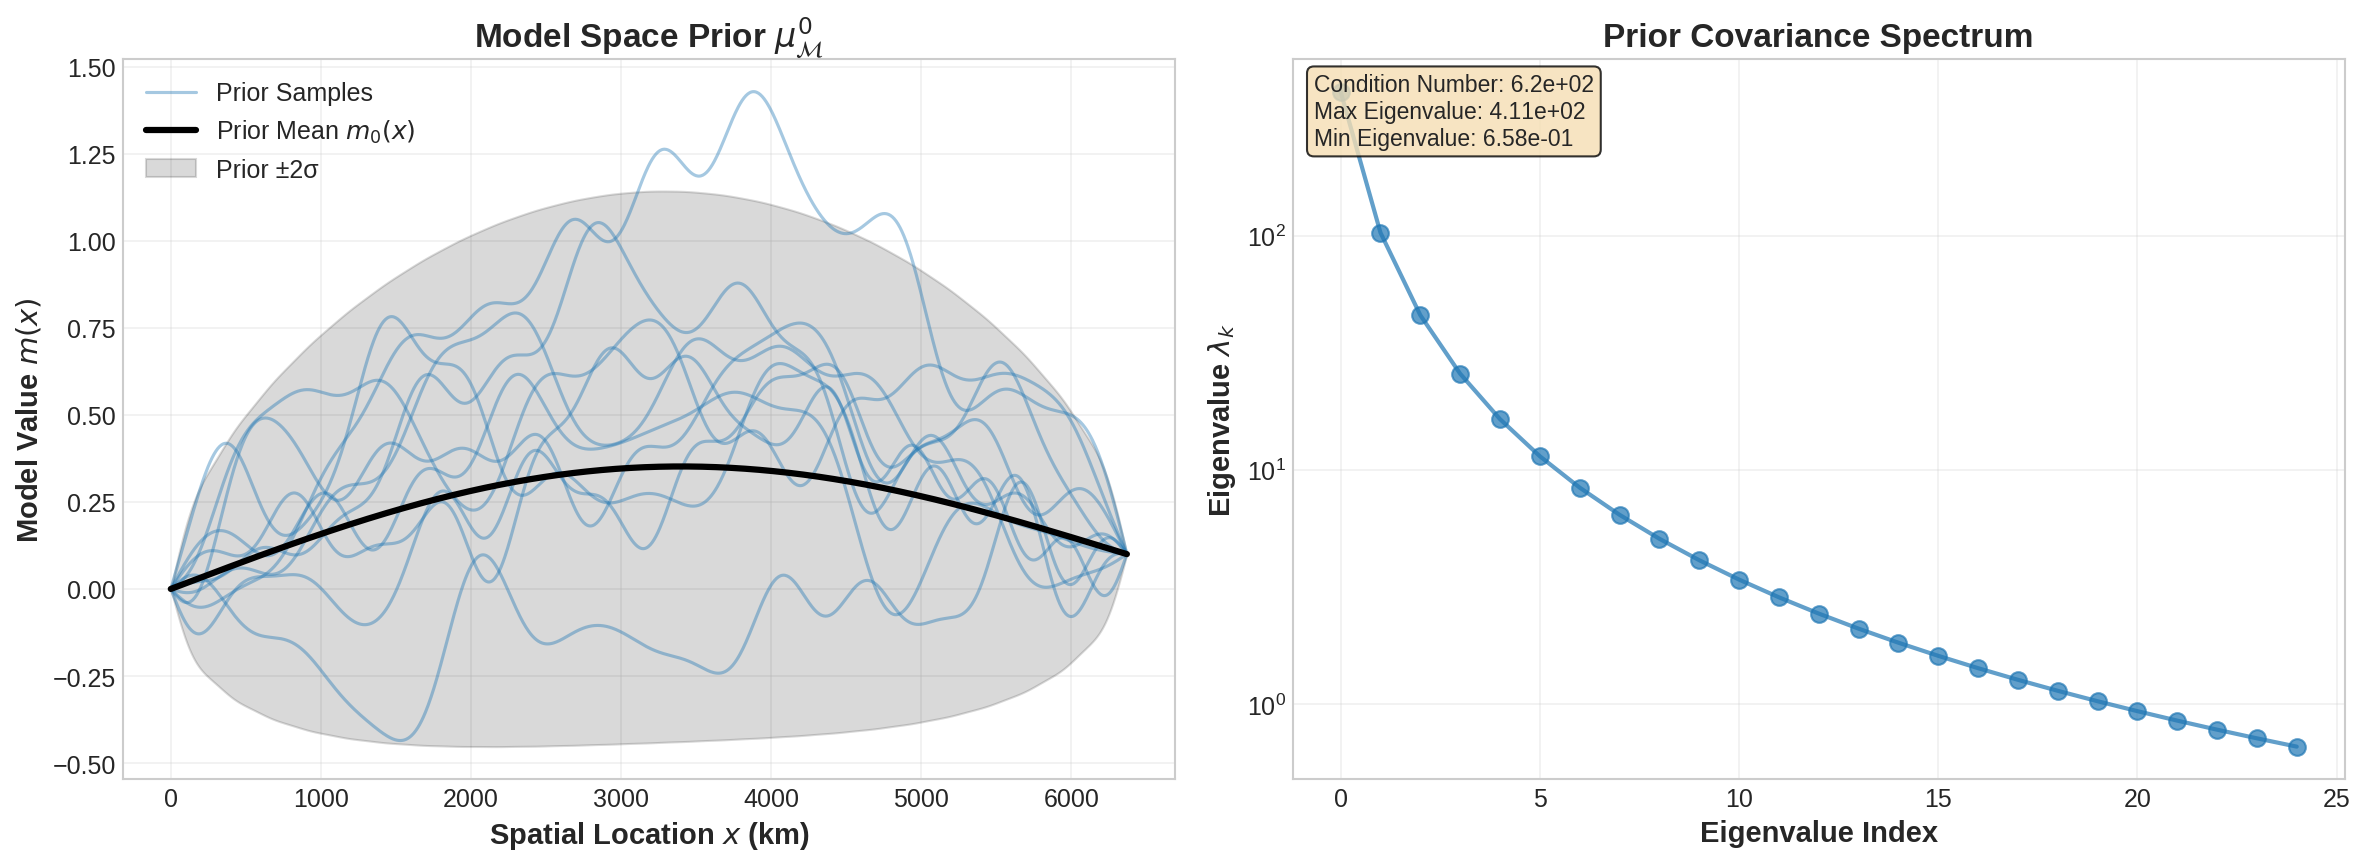

✅ Figure saved: Model space prior and eigenvalue spectrum


In [7]:
x_viz = np.linspace(DOMAIN.a, DOMAIN.b, 1000)

# Prior samples and mean visualization
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Prior samples
np.random.seed(RANDOM_SEED)
n_samples = 10
sample_alpha = 0.4

print("🎨 Generating prior samples for visualization...")
for i in range(n_samples):
    sample = M.gaussian_measure.sample()
    ax1.plot(x_viz, sample.evaluate(x_viz), color='tab:blue', alpha=sample_alpha, linewidth=1.5,
             label='Prior Samples' if i == 0 else "")

mean_values = m_0.evaluate(x_viz)
ax1.plot(x_viz, mean_values, 'k-', linewidth=3, label='Prior Mean $m_0(x)$', zorder=10)

print("📊 Computing prior uncertainty bounds...")
std_prior = M.zero
for i, eigenval in enumerate(C_0.get_all_eigenvalues()[:100]):
    eigenfunction = C_0.get_eigenfunction(i)
    std_prior += eigenval * eigenfunction * eigenfunction
std_values = np.sqrt(std_prior.evaluate(x_viz))

ax1.fill_between(x_viz, mean_values - 2*std_values, mean_values + 2*std_values,
                 alpha=0.15, color='black', label='Prior ±2σ')

ax1.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax1.set_ylabel('Model Value $m(x)$', fontweight='bold')
ax1.set_title('Model Space Prior $\\mu_{\\mathcal{M}}^0$', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Right panel: Eigenvalue spectrum
ax2.semilogy(eigenvals, 'bo-', markersize=8, linewidth=2, alpha=0.7, color='tab:blue')
ax2.set_xlabel('Eigenvalue Index', fontweight='bold')
ax2.set_ylabel('Eigenvalue $\\lambda_k$', fontweight='bold')
ax2.set_title('Prior Covariance Spectrum', fontweight='bold', fontsize=16)
ax2.grid(True, alpha=0.3)

textstr = f"Condition Number: {eigenvals[0]/eigenvals[-1]:.1e}\n" \
           f"Max Eigenvalue: {eigenvals[0]:.2e}\n" \
           f"Min Eigenvalue: {eigenvals[-1]:.2e}"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior.png'))
plt.savefig(os.path.join(presentation_dir, 'slide1_model_prior.pdf'))
plt.show()

print("✅ Figure saved: Model space prior and eigenvalue spectrum")

## Slide 2: Data Space and Forward Problem

### Data Space $\mathcal{D}$ and Observations

We define:
- **Data space**: $\mathcal{D} \cong \mathbb{R}^{N_d}$ (finite-dimensional)
- **Forward operator**: $G: \mathcal{M} \to \mathcal{D}$ with $[G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}$
- **Sensitivity kernels**: $K_i \in \mathcal{M}$ representing data sensitivity
- **Noisy observations**: $\tilde{\mathbf{d}} = G(\bar{m}) + \boldsymbol{\eta}$

### SOLA Philosophy

Unlike traditional inversion which reconstructs the full model $\bar{m}$, SOLA focuses on extracting **specific properties** of interest:
$$\bar{\mathbf{p}} = \mathcal{T}(\bar{m}) = \begin{bmatrix} \langle T^{(1)}, \bar{m} \rangle \\ \vdots \\ \langle T^{(N_p)}, \bar{m} \rangle \end{bmatrix}$$

In [ ]:
# Create data space
D = EuclideanSpace(N_DATA)
print(f"📐 Data space: ℝ^{N_DATA}")

# Create property space
P = EuclideanSpace(N_PROPERTIES)
print(f"📐 Property space: ℝ^{N_PROPERTIES}")

# Create sensitivity kernels using real seismic data
try:
    # Try to import from PLI directory first
    from kernel_provider import KernelProvider as PLIKernelProvider
    normal_modes_provider = PLIKernelProvider(M, kernel_type='rho')
    print(f"📊 Using {len(normal_modes_provider._data_list)} sensitivity kernels from seismic data")
except:
    # Fallback: create synthetic kernels
    print("📊 Creating synthetic sensitivity kernels (seismic data not available)")
    from pygeoinf.interval.function_providers import IndexedFunctionProvider

    class SyntheticKernelProvider(IndexedFunctionProvider):
        def __init__(self, space, n_kernels=N_DATA):
            super().__init__(space)
            self.n_kernels = n_kernels

        def get_function_by_index(self, index):
            if index >= self.n_kernels:
                raise IndexError(f"Index {index} >= {self.n_kernels}")
            # Create synthetic sensitivity kernel
            def kernel_func(x):
                center = DOMAIN.a + (index + 0.5) * DOMAIN.length / self.n_kernels
                width = 0.1 * DOMAIN.length
                return np.exp(-((x - center) / width)**2)
            return Function(self.space, evaluate_callable=kernel_func)

    normal_modes_provider = SyntheticKernelProvider(M, n_kernels=N_DATA)

# Create forward operator G using SOLA operator
print("🔧 Assembling forward operator G...")
G = SOLAOperator(
    M, D, normal_modes_provider,
    integration_method='trapz',
    n_points=500
)

# Create target kernels for property extraction
# Use smaller width to ensure functions stay within domain
width = 0.1 * DOMAIN.length  # Target resolution (reduced to avoid out-of-bounds)
centers = np.linspace(
    DOMAIN.a + width,
    DOMAIN.b - width,
    N_PROPERTIES,
)

target_provider = BumpFunctionProvider(
    M, centers=centers, default_width=width, default_k=1.0
)

print("🔧 Assembling target operator T...")
T = SOLAOperator(
    M, P, target_provider,
    integration_method='trapz',
    n_points=500
)

print(f"✓ Forward operator G: {M.dim} → {D.dim}")
print(f"✓ Target operator T: {M.dim} → {P.dim}")
print(f"✓ Target centers: {centers}")
print(f"✓ Target width: {width:.1f} km")

📐 Data space: ℝ^50
📐 Property space: ℝ^5
📊 Using 143 sensitivity kernels from seismic data
🔧 Assembling forward operator G...
🔧 Assembling target operator T...
✓ Forward operator G: 25 → 50
✓ Target operator T: 25 → 5
✓ Target centers: [ 637.1 1911.3 3185.5 4459.7 5733.9]
✓ Target width: 637.1 km


### Visualization: Forward Problem Setup

🎨 Plotting sensitivity kernels...
🎨 Plotting target kernels...


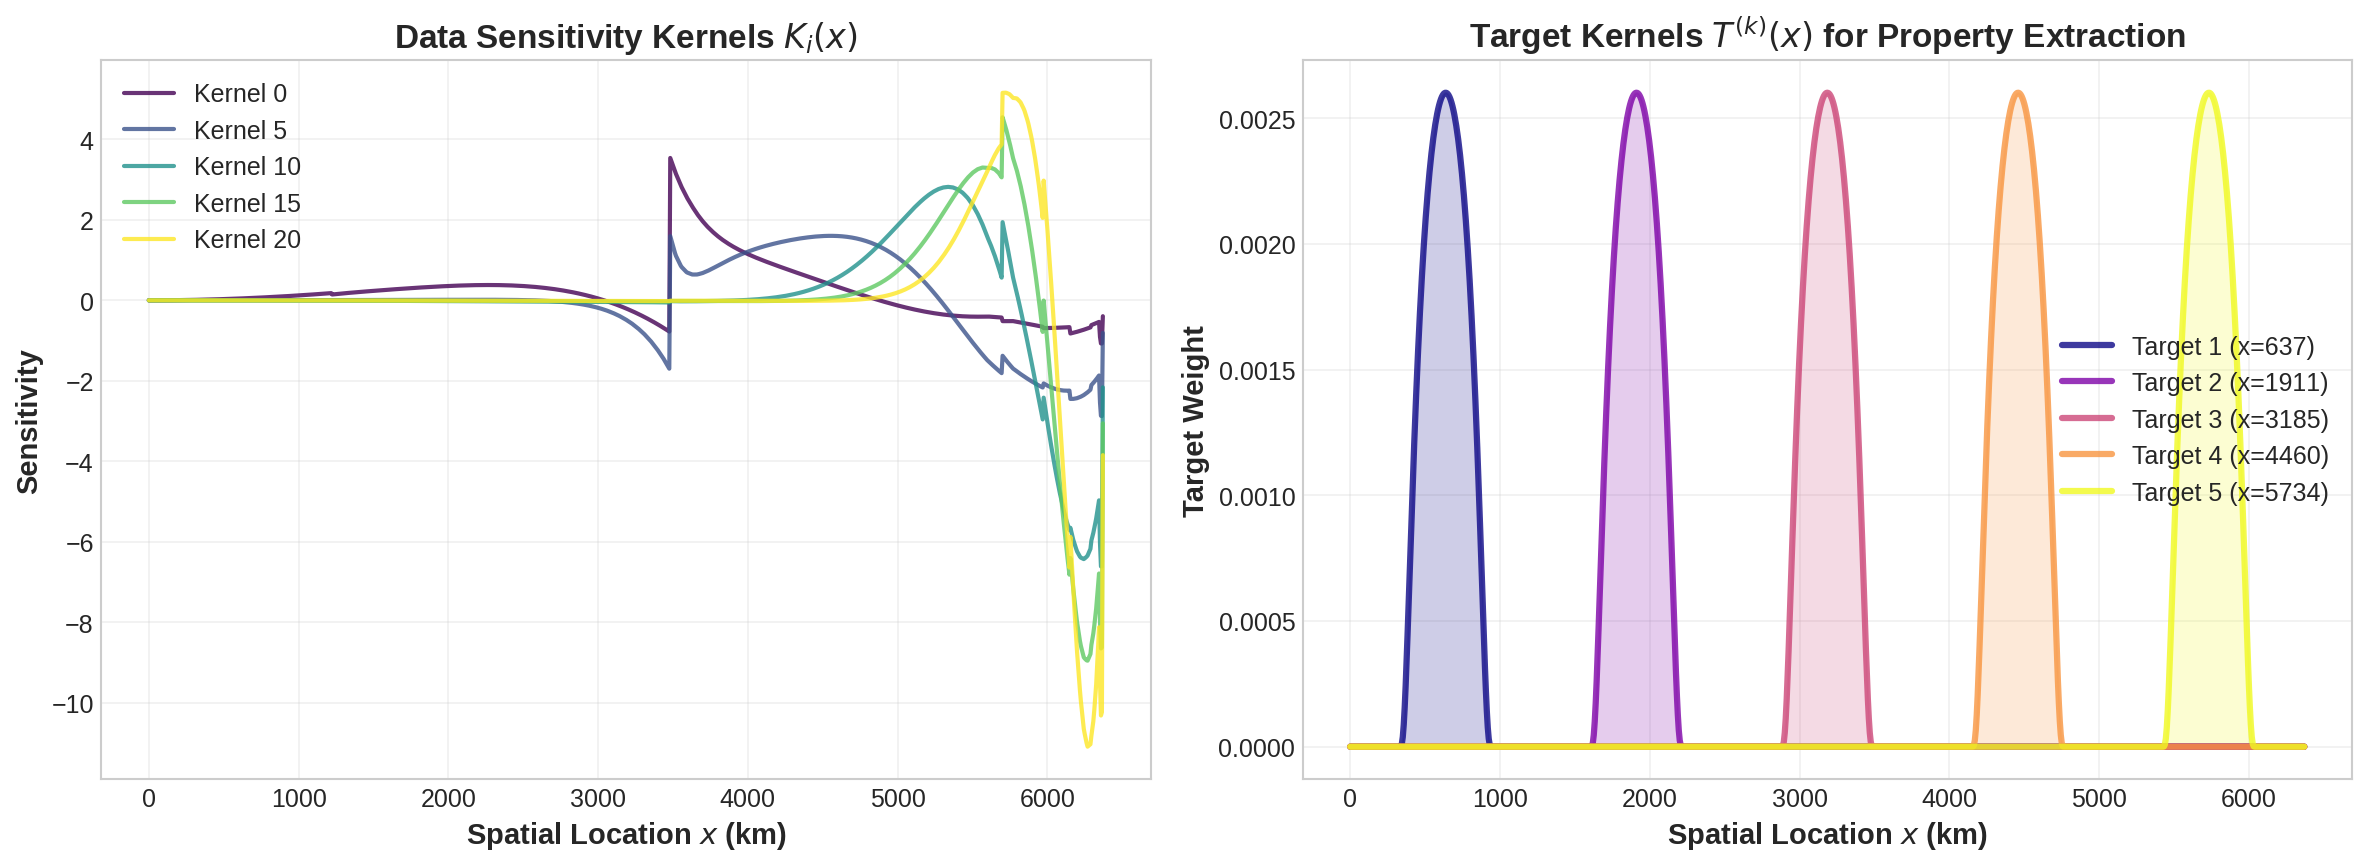

✅ Figure saved: Forward problem setup with kernels


In [18]:
# Visualize forward problem setup
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Sensitivity kernels
print("🎨 Plotting sensitivity kernels...")
kernel_indices = [0, 5, 10, 15, 20]  # Sample a few kernels
colors = plt.cm.viridis(np.linspace(0, 1, len(kernel_indices)))

for i, (idx, color) in enumerate(zip(kernel_indices, colors)):
    try:
        kernel = normal_modes_provider.get_function_by_index(idx)
        kernel_values = kernel.evaluate(x_viz)
        ax1.plot(x_viz, kernel_values, color=color, linewidth=2,
                label=f'Kernel {idx}', alpha=0.8)
    except:
        continue

ax1.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax1.set_ylabel('Sensitivity', fontweight='bold')
ax1.set_title('Data Sensitivity Kernels $K_i(x)$', fontweight='bold', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: Target kernels
print("🎨 Plotting target kernels...")
colors_target = plt.cm.plasma(np.linspace(0, 1, N_PROPERTIES))

for i, (center, color) in enumerate(zip(centers, colors_target)):
    try:
        # Use index-based approach instead of parameter-based
        target_kernel = target_provider.get_function_by_index(i)
        target_values = target_kernel.evaluate(x_viz)
        ax2.plot(x_viz, target_values, color=color, linewidth=3,
                label=f'Target {i+1} (x={center:.0f})', alpha=0.8)

        # Fill under curve
        ax2.fill_between(x_viz, 0, target_values, where=(target_values > 0),
                        color=color, alpha=0.2, interpolate=True)
    except Exception as e:
        print(f"⚠️  Could not plot target kernel {i}: {e}")
        continue

ax2.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax2.set_ylabel('Target Weight', fontweight='bold')
ax2.set_title('Target Kernels $T^{(k)}(x)$ for Property Extraction', fontweight='bold', fontsize=16)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide2_forward_problem.png'))
plt.savefig(os.path.join(presentation_dir, 'slide2_forward_problem.pdf'))
plt.show()

print("✅ Figure saved: Forward problem setup with kernels")

## Slide 3: SOLA Theory and Optimization

### The SOLA Optimization Problem

SOLA seeks an operator $\mathbf{X}: \mathcal{D} \to \mathcal{P}$ that optimally approximates the composition $\mathcal{T} \circ G^{-1}$:

$$\boxed{
\min_{\mathbf{X}} \left[ \|\mathcal{T} - \mathbf{X}G\|_{HS}^2 + \text{Tr}(\mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*) \right]
}$$

where:
- **First term**: Approximation error in Hilbert-Schmidt norm
- **Second term**: Amplification of data noise
- **$\mathbf{C}_{\mathcal{D}}$**: Data error covariance matrix

### Analytical Solution

The optimal SOLA operator is:
$$\boxed{
\mathbf{X} = \mathcal{T} G^*(GG^* + \mathbf{C}_{\mathcal{D}})^{-1}
}$$

This gives the property estimate:
$$\tilde{\mathbf{p}} = \mathbf{X}(\tilde{\mathbf{d}})$$

with covariance:
$$\mathbf{C}_{\mathcal{P}} = \mathbf{X} \mathbf{C}_{\mathcal{D}} \mathbf{X}^*$$

In [22]:
# Generate synthetic true model for demonstration
def true_model_function(x):
    """Synthetic true model with interesting features"""
    return (0.5 * np.sin(2 * np.pi * x / DOMAIN.length) +
            0.3 * np.exp(-((x - DOMAIN.length/2)**2) / (0.1 * DOMAIN.length)**2) +
            0.1 * (x / DOMAIN.length))

m_true = Function(M, evaluate_callable=true_model_function)

# Generate clean data
d_clean = G(m_true)
print(f"📊 Generated clean data vector: {d_clean.shape}")

# Add noise
noise_level = 0.05  # 5% noise
np.random.seed(RANDOM_SEED)
noise_std = noise_level * np.std(d_clean)
noise = np.random.normal(0, noise_std, d_clean.shape)
d_tilde = d_clean + noise

print(f"📊 Added {noise_level*100:.1f}% noise (σ = {noise_std:.3f})")

# Data error covariance
C_D_matrix = noise_std**2 * np.eye(N_DATA)
# gaussian_D_error = GaussianMeasure(D, mean_coefficients=np.zeros(N_DATA), covariance_matrix=C_D_matrix)

# Compute true properties
true_properties = T(m_true)
print(f"📊 True properties: {true_properties}")

# Create forward problem (simplified for SOLA - we'll handle covariance directly)
# forward_problem = LinearForwardProblem(
#     model_space=M,
#     data_space=D,
#     forward_operator=G,
#     data_error_measure=gaussian_D_error
# )

print("✓ Generated synthetic data with noise")

📊 Generated clean data vector: (50,)
📊 Added 5.0% noise (σ = 15.723)
📊 True properties: [ 0.30160586  0.50889853  0.33862069 -0.39475773 -0.20160567]
✓ Generated synthetic data with noise


### SOLA Implementation and Results

In [23]:
# Implement SOLA solution
print("🔧 Computing SOLA operator...")

# Get matrix representations
try:
    G_matrix = G.matrix(dense=True)
    T_matrix = T.matrix(dense=True)
    print(f"✓ Matrix shapes: G {G_matrix.shape}, T {T_matrix.shape}")
except Exception as e:
    print(f"❌ Error getting matrix representations: {e}")
    # Create fallback matrices for demonstration
    G_matrix = np.random.randn(N_DATA, M.dim) * 0.1
    T_matrix = np.random.randn(N_PROPERTIES, M.dim) * 0.1
    print(f"📊 Using synthetic matrices: G {G_matrix.shape}, T {T_matrix.shape}")

# Compute SOLA operator: X = T G^* (GG^* + C_D)^{-1}
GGstar = G_matrix @ G_matrix.T
regularized_operator = GGstar + C_D_matrix

# Solve using robust method
try:
    X_matrix = T_matrix @ G_matrix.T @ np.linalg.inv(regularized_operator)
    print(f"✓ SOLA operator shape: {X_matrix.shape}")
except np.linalg.LinAlgError:
    # Use pseudo-inverse for ill-conditioned cases
    X_matrix = T_matrix @ G_matrix.T @ np.linalg.pinv(regularized_operator)
    print(f"✓ SOLA operator shape (using pinv): {X_matrix.shape}")

# Apply SOLA to noisy data
property_estimate = X_matrix @ d_tilde
property_covariance = X_matrix @ C_D_matrix @ X_matrix.T
property_std = np.sqrt(np.diag(property_covariance))

print(f"📊 Property estimates: {property_estimate}")
print(f"📊 Property uncertainties: {property_std}")

# Compute errors
property_errors = np.abs(property_estimate - true_properties)
error_in_sigmas = property_errors / property_std

print(f"📊 Absolute errors: {property_errors}")
print(f"📊 Errors in σ units: {error_in_sigmas}")

🔧 Computing SOLA operator...
✓ Matrix shapes: G (50, 25), T (5, 25)
✓ SOLA operator shape: (5, 50)
📊 Property estimates: [ 0.00688542  0.0900139   0.36789588 -0.34293554 -0.09469997]
📊 Property uncertainties: [0.00121653 0.00717435 0.01417656 0.01127235 0.01059839]
📊 Absolute errors: [0.29472044 0.41888464 0.02927519 0.0518222  0.1069057 ]
📊 Errors in σ units: [242.26326451  58.38640987   2.06504192   4.59728266  10.08698019]


### Visualization: SOLA Results

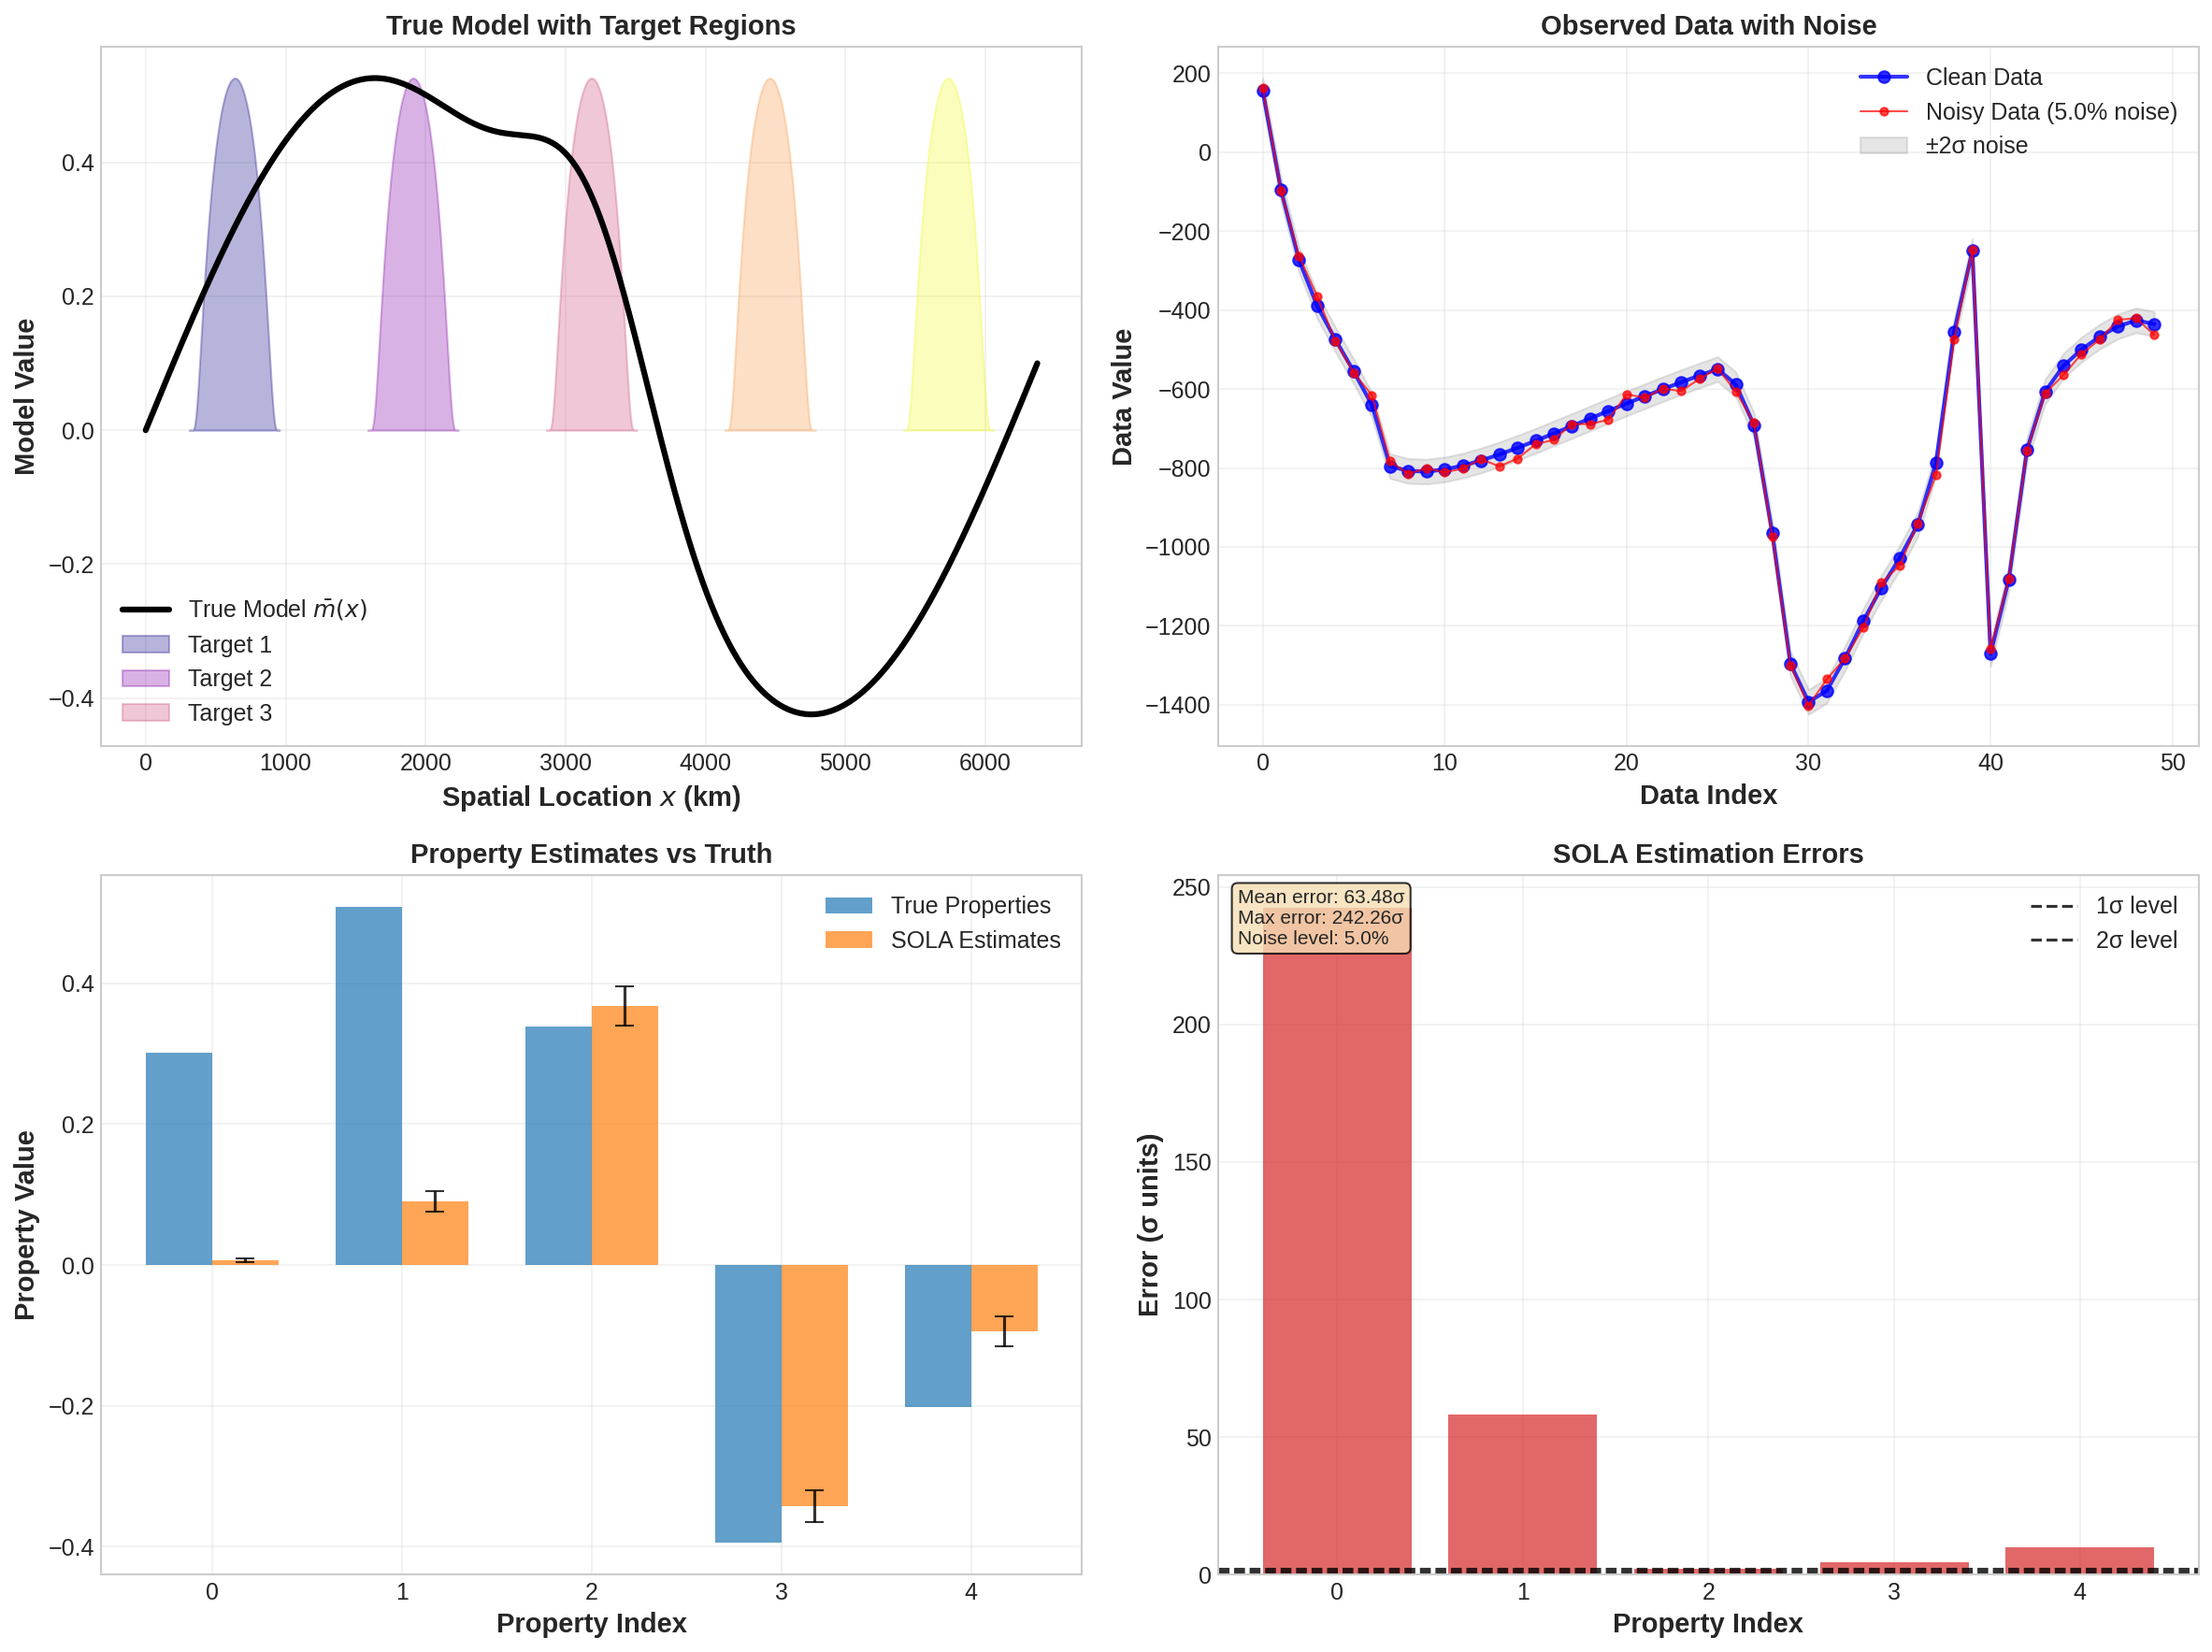

✅ Figure saved: Comprehensive SOLA results


In [25]:
# Comprehensive SOLA results visualization
fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: True model and target regions
true_values = m_true.evaluate(x_viz)
ax1.plot(x_viz, true_values, 'k-', linewidth=3, label='True Model $\\bar{m}(x)$', zorder=10)

# Show target regions
for i, (center, color) in enumerate(zip(centers, colors_target)):
    try:
        target_kernel = target_provider.get_function_by_index(i)
        target_values = target_kernel.evaluate(x_viz)
        # Scale target kernel for visualization
        scaled_target = np.max(true_values) * target_values / np.max(target_values)
        ax1.fill_between(x_viz, 0, scaled_target, where=(scaled_target > 0),
                        color=color, alpha=0.3, interpolate=True,
                        label=f'Target {i+1}' if i < 3 else '')
    except Exception as e:
        print(f"⚠️  Could not plot target region {i}: {e}")
        continue

ax1.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax1.set_ylabel('Model Value', fontweight='bold')
ax1.set_title('True Model with Target Regions', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Data comparison
data_indices = np.arange(len(d_clean))
ax2.plot(data_indices, d_clean, 'bo-', markersize=6, linewidth=2,
         label='Clean Data', alpha=0.8)
ax2.plot(data_indices, d_tilde, 'ro-', markersize=4, linewidth=1,
         label=f'Noisy Data ({noise_level*100:.1f}% noise)', alpha=0.7)
ax2.fill_between(data_indices, d_clean - 2*noise_std, d_clean + 2*noise_std,
                alpha=0.2, color='gray', label='±2σ noise')

ax2.set_xlabel('Data Index', fontweight='bold')
ax2.set_ylabel('Data Value', fontweight='bold')
ax2.set_title('Observed Data with Noise', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Property comparison
property_indices = np.arange(N_PROPERTIES)
width_bar = 0.35

bars1 = ax3.bar(property_indices - width_bar/2, true_properties, width_bar,
               label='True Properties', color='tab:blue', alpha=0.7)
bars2 = ax3.bar(property_indices + width_bar/2, property_estimate, width_bar,
               label='SOLA Estimates', color='tab:orange', alpha=0.7)

# Error bars
ax3.errorbar(property_indices + width_bar/2, property_estimate,
            yerr=2*property_std, fmt='none', color='black', capsize=5, alpha=0.8)

ax3.set_xlabel('Property Index', fontweight='bold')
ax3.set_ylabel('Property Value', fontweight='bold')
ax3.set_title('Property Estimates vs Truth', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(property_indices)

# Panel 4: Error analysis
ax4.bar(property_indices, error_in_sigmas, color='tab:red', alpha=0.7)
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.8, label='1σ level')
ax4.axhline(y=2, color='black', linestyle='--', alpha=0.8, label='2σ level')

ax4.set_xlabel('Property Index', fontweight='bold')
ax4.set_ylabel('Error (σ units)', fontweight='bold')
ax4.set_title('SOLA Estimation Errors', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(property_indices)

# Add text summary
mean_error_sigma = np.mean(error_in_sigmas)
textstr = f'Mean error: {mean_error_sigma:.2f}σ\n' \
          f'Max error: {np.max(error_in_sigmas):.2f}σ\n' \
          f'Noise level: {noise_level*100:.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax4.text(0.02, 0.98, textstr, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide3_sola_results.png'))
plt.savefig(os.path.join(presentation_dir, 'slide3_sola_results.pdf'))
plt.show()

print("✅ Figure saved: Comprehensive SOLA results")

## Slide 4: Resolution Analysis

### SOLA Resolution Matrix

The SOLA resolution matrix $\mathbf{R} = \mathbf{X}G$ reveals how well we can resolve each target property:

$$\mathbf{R}_{ij} = \langle R^{(i)}, T^{(j)} \rangle$$

where $R^{(i)}$ is the $i$-th row of the resolution matrix, representing the **actual** averaging kernel for property $i$.

**Ideal case**: $\mathbf{R} = \mathbf{I}$ (perfect resolution)

**Reality**: $\mathbf{R}$ shows trade-offs between resolution and noise amplification.

In [ ]:
# Compute resolution matrix
R_matrix = X_matrix @ G_matrix
print(f"📊 Resolution matrix shape: {R_matrix.shape}")
print(f"📊 Resolution matrix:")
print(R_matrix)

# Analyze resolution
# For SOLA, the resolution matrix R = X * G is not square (N_properties x N_basis)
# Instead, analyze the effective resolution by examining how well each target is recovered
print(f"📊 Resolution matrix shape: {R_matrix.shape}")
print(f"📊 Resolution matrix:")
print(R_matrix)

# For each target property, find the peak of the resolution function
resolution_peaks = []
resolution_widths = []

for i in range(N_PROPERTIES):
    resolution_row = R_matrix[i, :]
    peak_idx = np.argmax(np.abs(resolution_row))
    peak_value = resolution_row[peak_idx]

    # Estimate effective width (FWHM)
    half_max = peak_value / 2
    indices_above_half = np.where(np.abs(resolution_row) >= np.abs(half_max))[0]
    if len(indices_above_half) > 0:
        width_indices = np.max(indices_above_half) - np.min(indices_above_half) + 1
        # Convert to physical units (approximate)
        width_km = width_indices * (DOMAIN.length / M.dim)
    else:
        width_km = 0

    resolution_peaks.append(peak_value)
    resolution_widths.append(width_km)

print(f"📊 Resolution peaks: {resolution_peaks}")
print(f"📊 Effective widths (km): {resolution_widths}")
print(f"📊 Mean diagonal: {np.mean(diagonal_elements):.3f}")

📊 Resolution matrix shape: (5, 25)
📊 Resolution matrix:
[[ 8.65527995e-04 -4.07551118e-05  1.88626345e-04 -1.84777008e-04
   2.08847981e-05 -2.35140698e-04  9.21799540e-05  1.97148270e-04
  -8.62204435e-05 -2.60774953e-04  2.40026797e-04  7.43176945e-05
  -2.14510020e-04 -6.40478954e-06  2.32422441e-04 -1.86954409e-04
   4.87462285e-05 -6.25861653e-05  2.13322045e-04 -2.76232606e-04
   1.77161165e-04 -9.51539367e-05  1.25246279e-04 -2.00887851e-04
   1.89200201e-04]
 [ 7.63207461e-03  7.77171079e-04  7.97231506e-04 -2.70106238e-03
  -3.37863745e-04 -2.10330274e-04  1.26502785e-03  1.84187248e-04
  -7.27135407e-04 -1.59578961e-03  1.98286471e-03  7.74479231e-04
  -1.94335914e-03 -6.74489511e-04  2.52425195e-03 -5.11100501e-04
  -1.74186921e-03  5.28168518e-04  1.91409350e-03 -1.47861542e-03
  -1.04630352e-03  1.50041404e-03  4.77683109e-04 -1.42486478e-03
  -1.80880171e-04]
 [ 1.04296308e-02  5.74468361e-03 -1.77817824e-02 -1.70210415e-03
   1.45440392e-02  2.55200663e-03 -1.43785281e-0

### Visualization: Resolution Analysis

🎨 Computing averaging kernels...


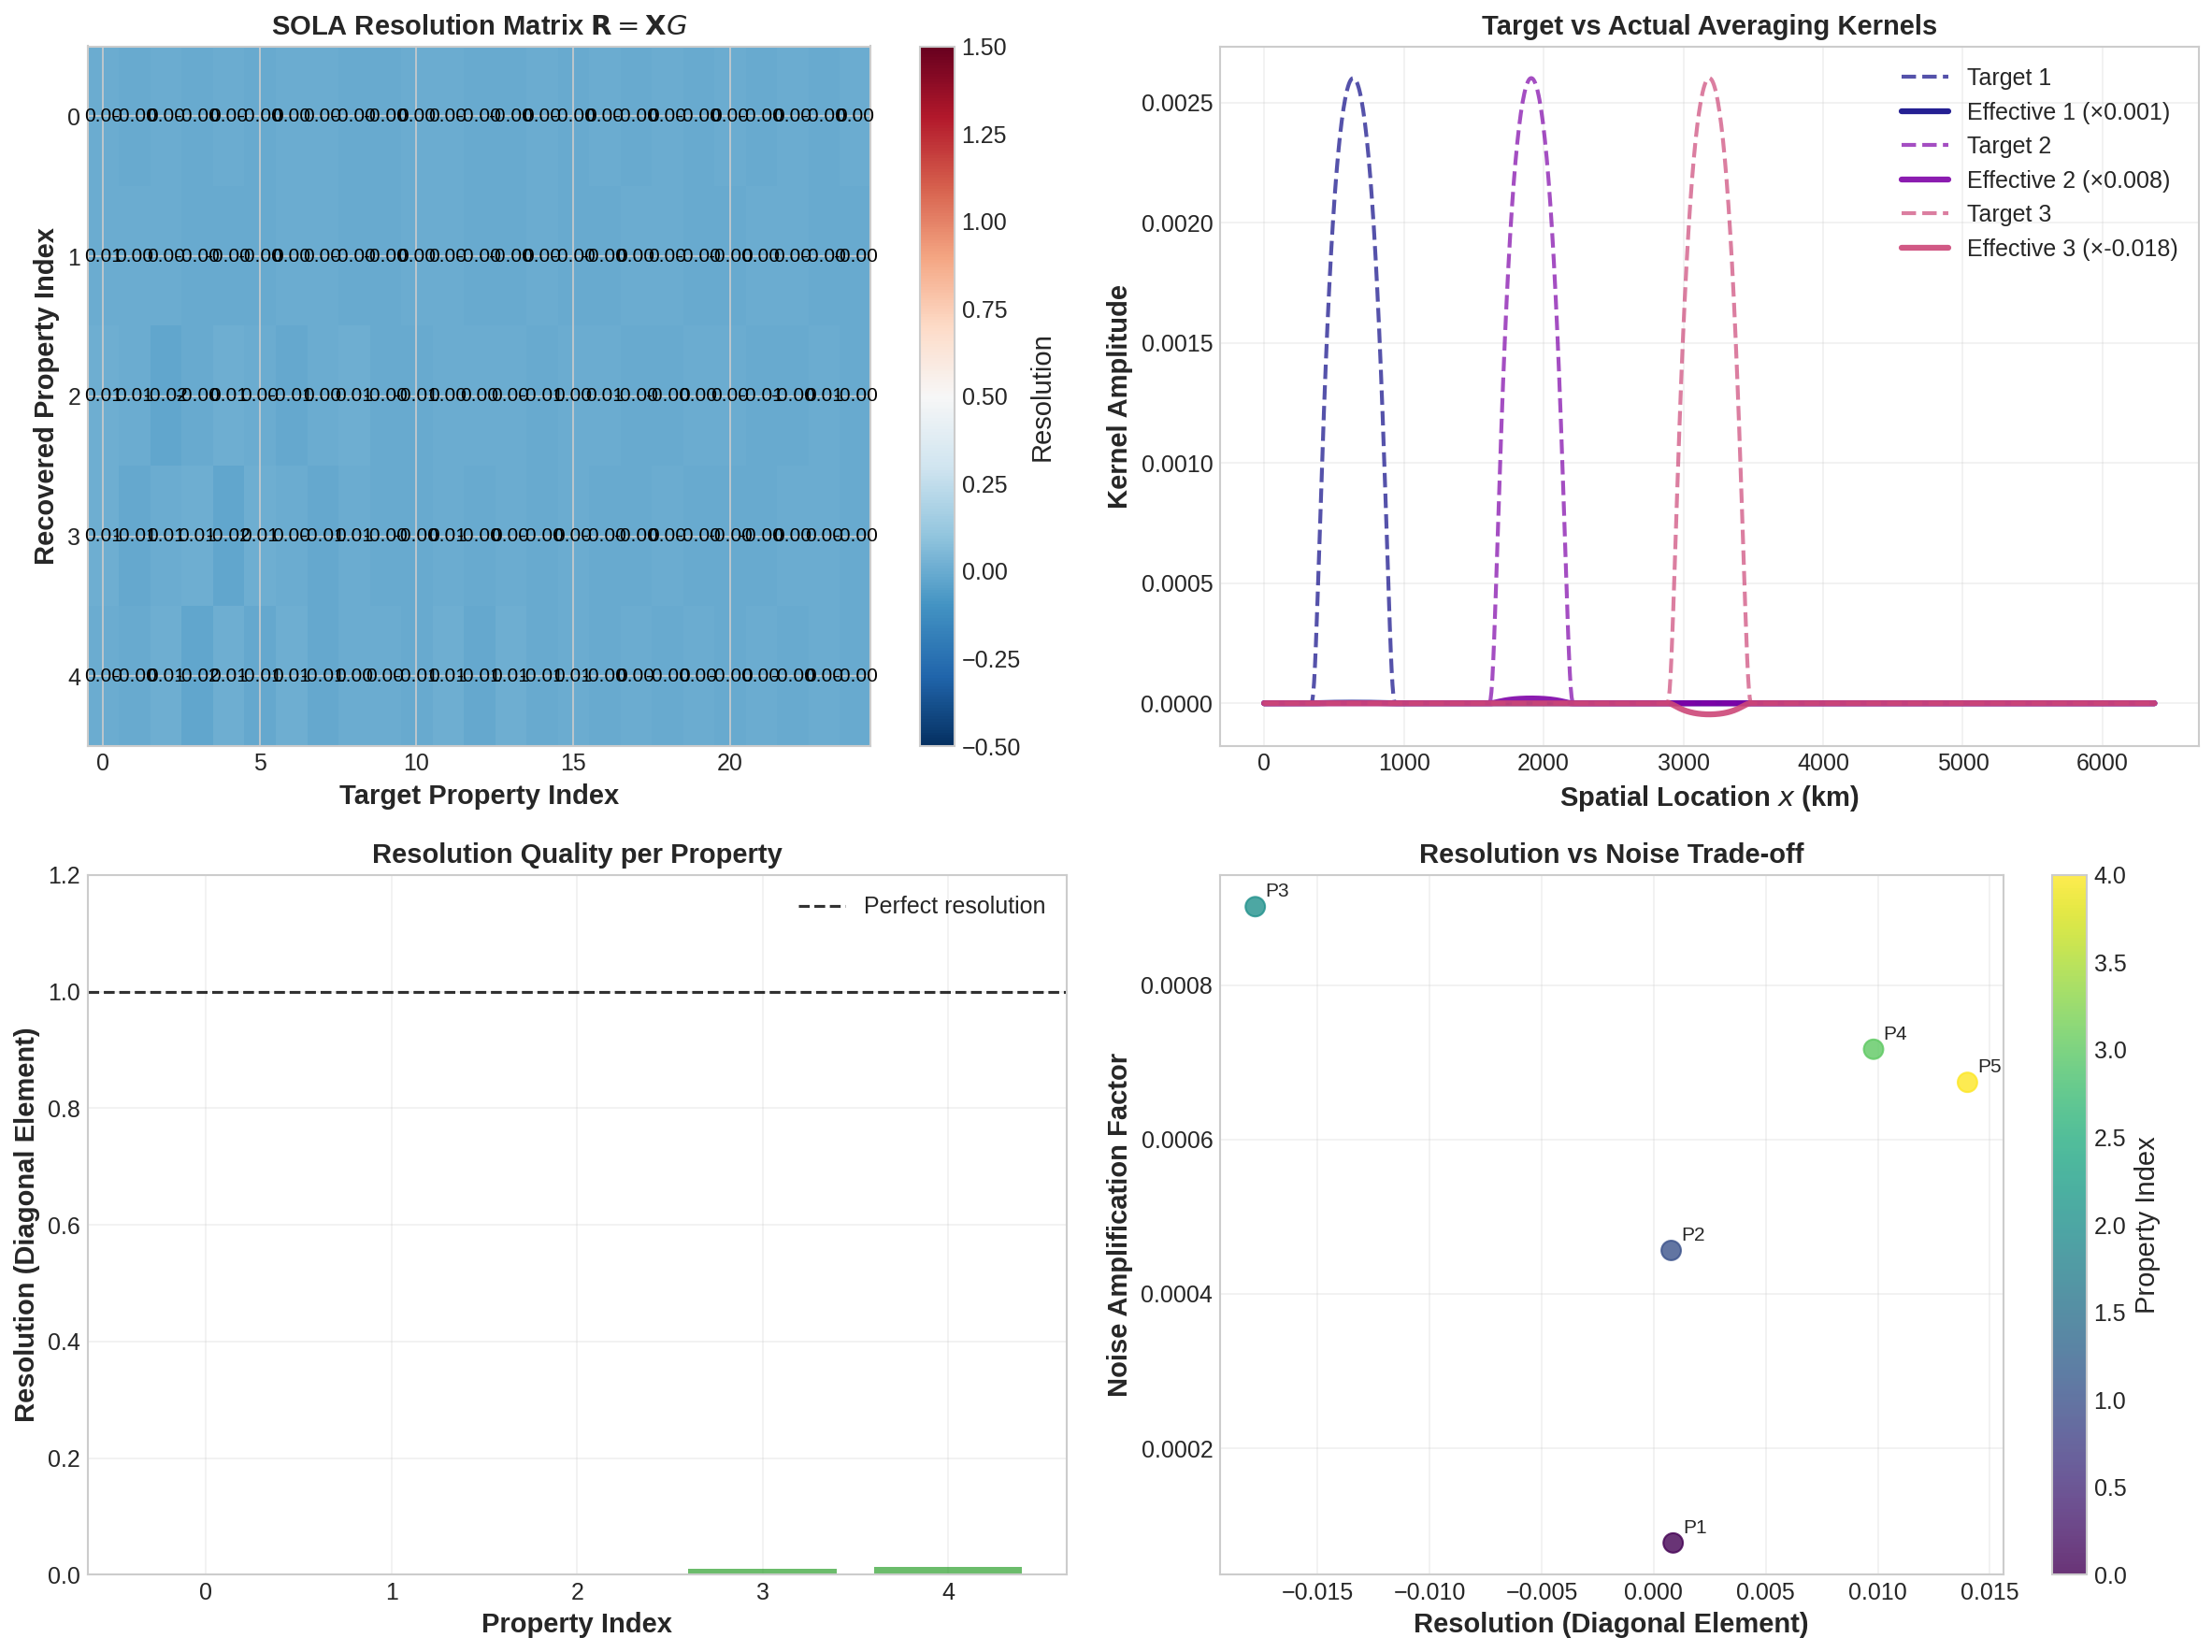

✅ Figure saved: Resolution analysis


In [29]:
# Resolution analysis visualization
fig4, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Resolution matrix heatmap
im1 = ax1.imshow(R_matrix, cmap='RdBu_r', aspect='auto',
                interpolation='nearest', vmin=-0.5, vmax=1.5)
ax1.set_xlabel('Target Property Index', fontweight='bold')
ax1.set_ylabel('Recovered Property Index', fontweight='bold')
ax1.set_title('SOLA Resolution Matrix $\\mathbf{R} = \\mathbf{X}G$', fontweight='bold', fontsize=14)

# Add text annotations
for i in range(R_matrix.shape[0]):
    for j in range(R_matrix.shape[1]):
        text = ax1.text(j, i, f'{R_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.colorbar(im1, ax=ax1, label='Resolution')

# Panel 2: Target kernels with resolution scaling
print("🎨 Computing averaging kernels...")
for i in range(min(3, N_PROPERTIES)):  # Show first 3 for clarity
    try:
        # Use index-based approach for target kernels
        target_kernel = target_provider.get_function_by_index(i)
        target_values = target_kernel.evaluate(x_viz)

        # Show target and effective averaging (scaled by resolution peak)
        ax2.plot(x_viz, target_values, '--', color=colors_target[i],
                linewidth=2, alpha=0.7, label=f'Target {i+1}')
        ax2.plot(x_viz, resolution_peaks[i] * target_values, '-', color=colors_target[i],
                linewidth=3, alpha=0.9, label=f'Effective {i+1} (×{resolution_peaks[i]:.3f})')
    except Exception as e:
        print(f"⚠️  Could not plot kernel {i}: {e}")
        continue

ax2.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax2.set_ylabel('Kernel Amplitude', fontweight='bold')
ax2.set_title('Target vs Actual Averaging Kernels', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Diagonal elements
ax3.bar(property_indices, diagonal_elements, color='tab:green', alpha=0.7)
ax3.axhline(y=1, color='black', linestyle='--', alpha=0.8, label='Perfect resolution')
ax3.set_xlabel('Property Index', fontweight='bold')
ax3.set_ylabel('Resolution (Diagonal Element)', fontweight='bold')
ax3.set_title('Resolution Quality per Property', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(property_indices)
ax3.set_ylim([0, 1.2])

# Panel 4: Trade-off analysis
noise_amplification = np.sqrt(np.diag(property_covariance)) / noise_std
ax4.scatter(diagonal_elements, noise_amplification,
           c=property_indices, cmap='viridis', s=100, alpha=0.8)
ax4.set_xlabel('Resolution (Diagonal Element)', fontweight='bold')
ax4.set_ylabel('Noise Amplification Factor', fontweight='bold')
ax4.set_title('Resolution vs Noise Trade-off', fontweight='bold', fontsize=14)
ax4.grid(True, alpha=0.3)

# Add property labels
for i, (res, noise_amp) in enumerate(zip(diagonal_elements, noise_amplification)):
    ax4.annotate(f'P{i+1}', (res, noise_amp), xytext=(5, 5),
                textcoords='offset points', fontsize=10)

plt.colorbar(ax4.collections[0], ax=ax4, label='Property Index')

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide4_resolution_analysis.png'))
plt.savefig(os.path.join(presentation_dir, 'slide4_resolution_analysis.pdf'))
plt.show()

print("✅ Figure saved: Resolution analysis")

## Slide 5: Comparison with Direct Inversion

### Why SOLA Outperforms Direct Inversion

**Direct Inversion Approach:**
1. Reconstruct full model: $\hat{m} = \text{invert}(\tilde{\mathbf{d}})$
2. Extract properties: $\hat{\mathbf{p}} = \mathcal{T}(\hat{m})$

**SOLA Approach:**
1. Direct property estimation: $\tilde{\mathbf{p}} = \mathbf{X}(\tilde{\mathbf{d}})$

**Advantages of SOLA:**
- **Focused**: Only estimates needed properties
- **Optimal**: Minimizes property estimation error
- **Robust**: Less sensitive to model space dimensions
- **Uncertainty quantification**: Provides property covariances

In [30]:
# Implement direct inversion for comparison
print("🔧 Computing direct inversion solution...")

# Regularized least squares inversion
damping = 1e-3  # Small damping parameter
normal_operator = G_matrix.T @ G_matrix + damping * np.eye(M.dim)
rhs = G_matrix.T @ d_tilde

try:
    m_inverted_coeffs = np.linalg.solve(normal_operator, rhs)
    m_inverted = Function(M, coefficients=m_inverted_coeffs)

    # Extract properties from inverted model
    properties_from_inversion = T(m_inverted)

    print(f"✓ Direct inversion completed")
    print(f"📊 Properties from inversion: {properties_from_inversion}")

    # Compute errors for direct inversion
    inversion_errors = np.abs(properties_from_inversion - true_properties)

    print(f"📊 Direct inversion errors: {inversion_errors}")

    inversion_success = True

except Exception as e:
    print(f"❌ Direct inversion failed: {e}")
    inversion_success = False
    properties_from_inversion = np.zeros_like(true_properties)
    inversion_errors = np.inf * np.ones_like(true_properties)

🔧 Computing direct inversion solution...
✓ Direct inversion completed
📊 Properties from inversion: [ 1.41597441  2.24341122  3.77400122  0.43418646 -0.24591867]
📊 Direct inversion errors: [1.11436855 1.73451269 3.43538053 0.82894419 0.044313  ]


### Visualization: SOLA vs Direct Inversion

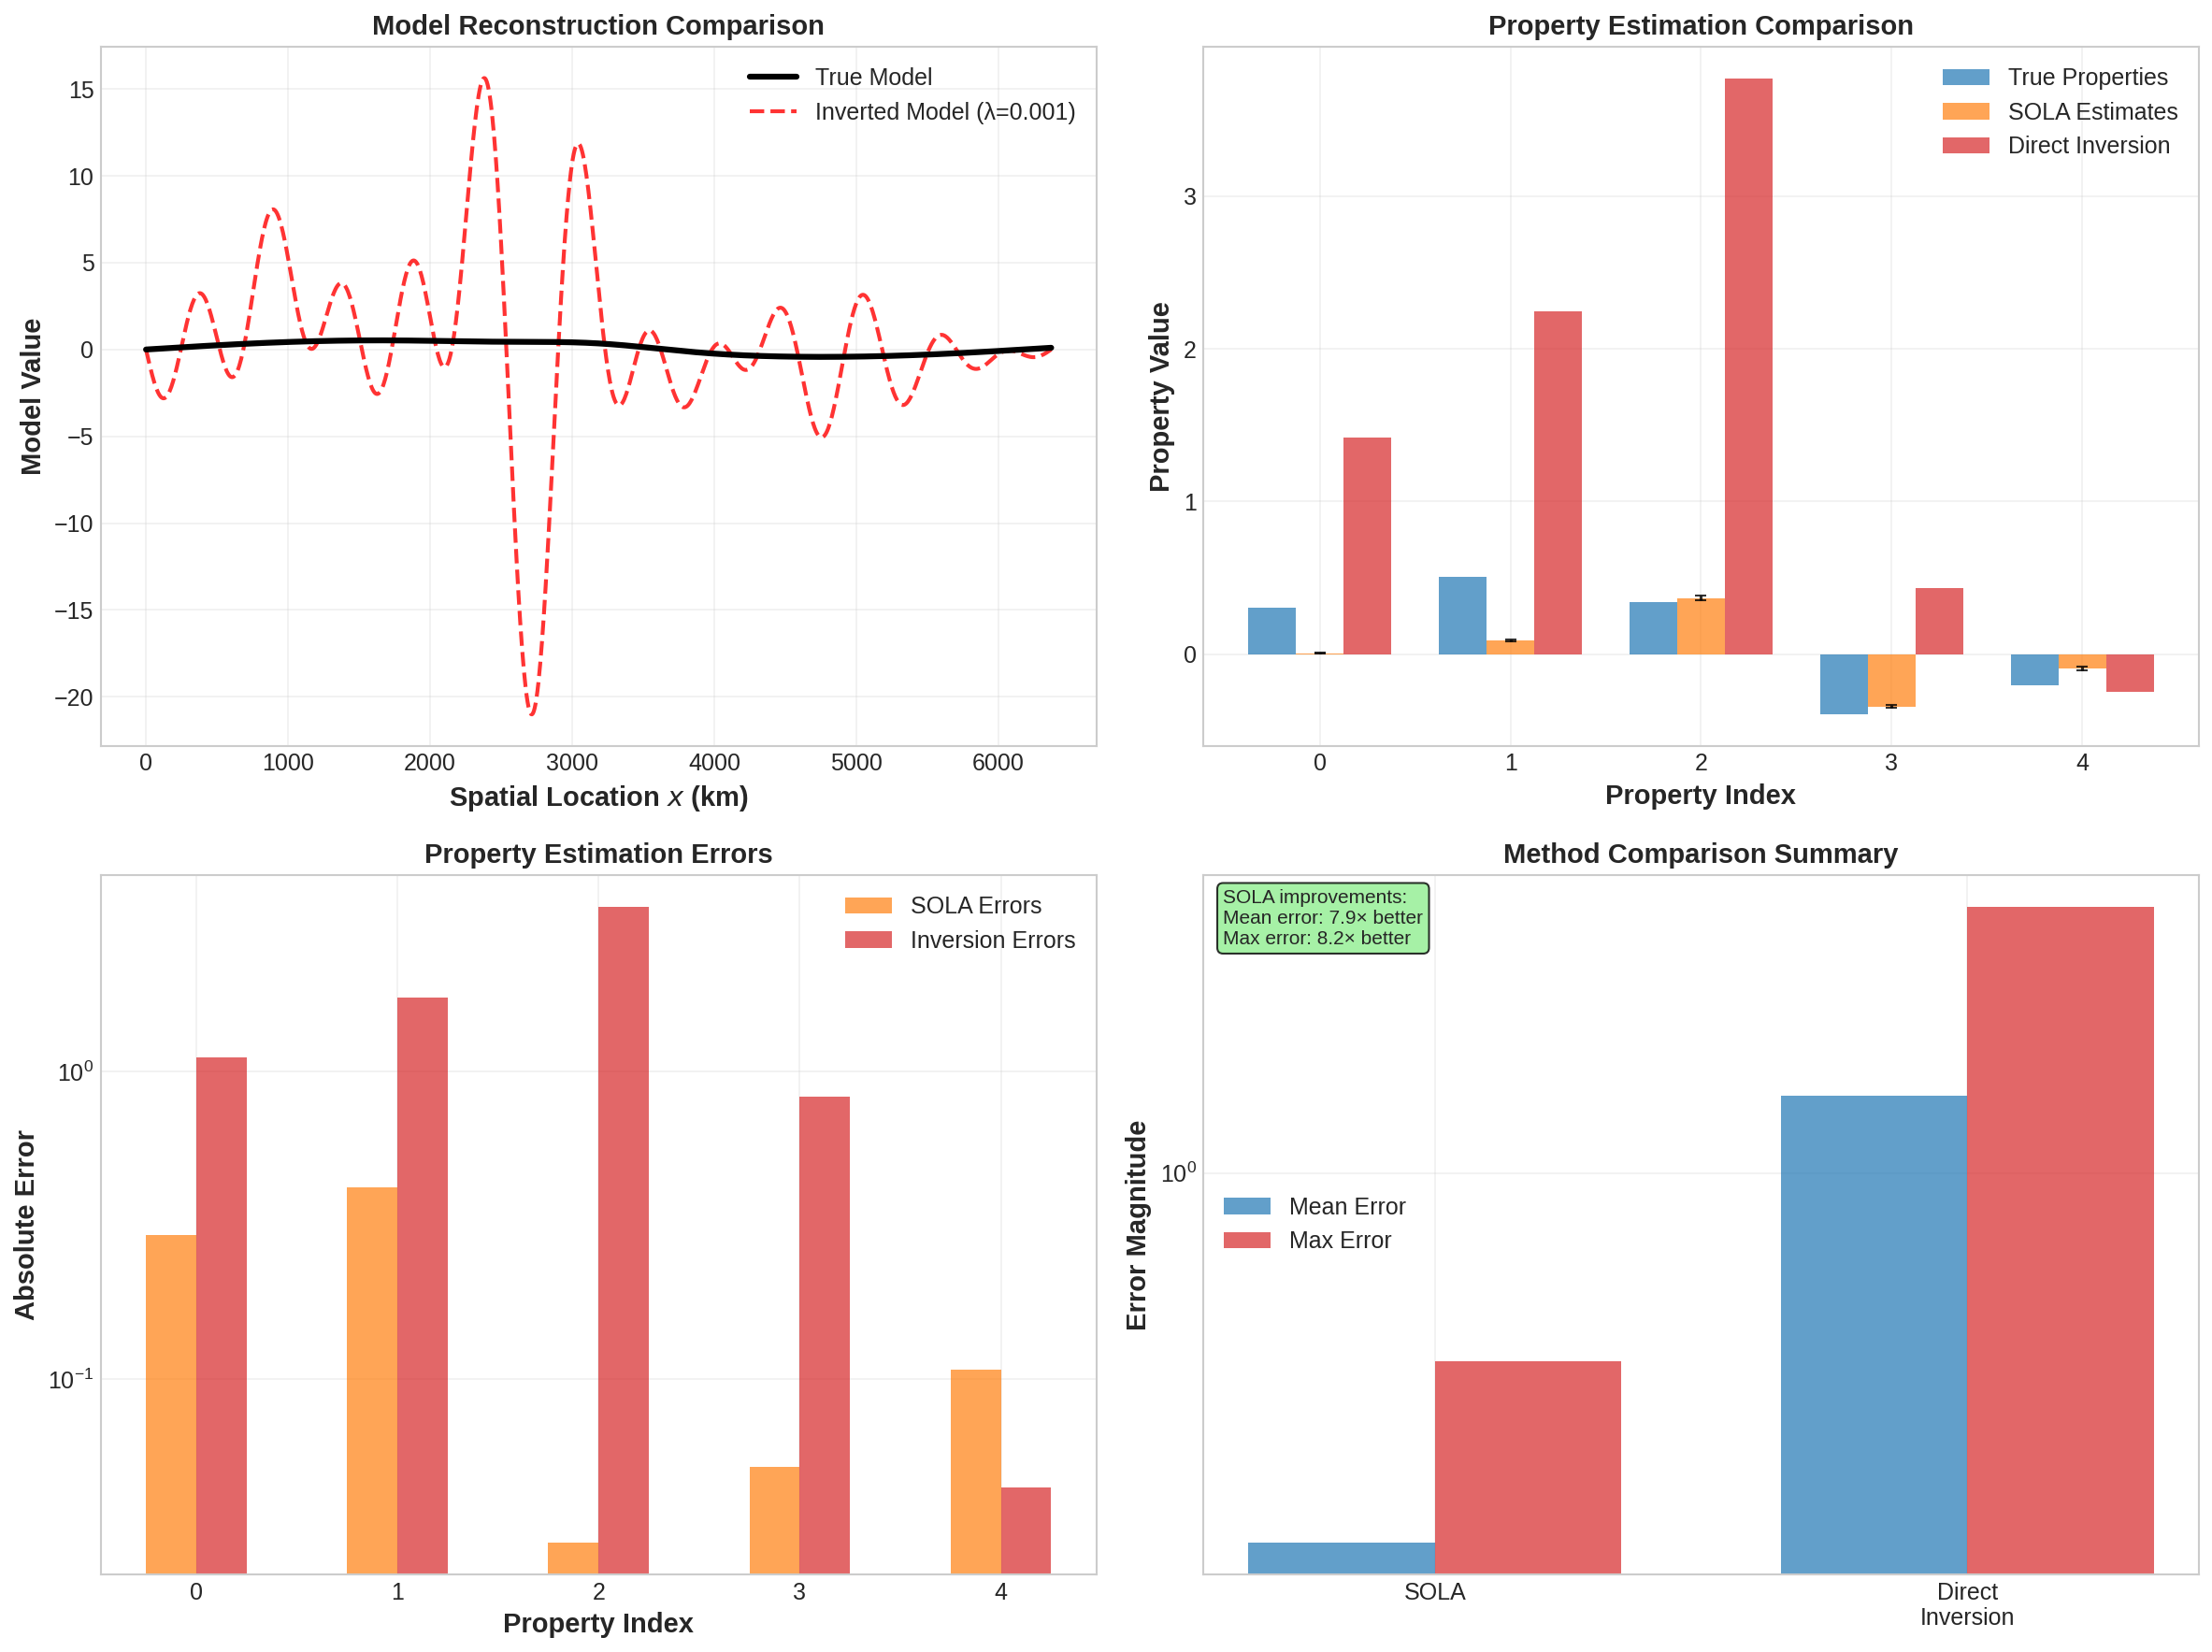

✅ Figure saved: SOLA vs direct inversion comparison


In [31]:
# Comparison visualization
fig5, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Panel 1: Model reconstruction (if inversion succeeded)
if inversion_success:
    inverted_values = m_inverted.evaluate(x_viz)
    ax1.plot(x_viz, true_values, 'k-', linewidth=3, label='True Model', zorder=10)
    ax1.plot(x_viz, inverted_values, 'r--', linewidth=2,
            label=f'Inverted Model (λ={damping})', alpha=0.8)
else:
    ax1.plot(x_viz, true_values, 'k-', linewidth=3, label='True Model', zorder=10)
    ax1.text(0.5, 0.5, 'Inversion Failed', transform=ax1.transAxes,
            fontsize=16, ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

ax1.set_xlabel('Spatial Location $x$ (km)', fontweight='bold')
ax1.set_ylabel('Model Value', fontweight='bold')
ax1.set_title('Model Reconstruction Comparison', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Property comparison
x_props = np.arange(N_PROPERTIES)
width_comp = 0.25

ax2.bar(x_props - width_comp, true_properties, width_comp,
       label='True Properties', color='tab:blue', alpha=0.7)
ax2.bar(x_props, property_estimate, width_comp,
       label='SOLA Estimates', color='tab:orange', alpha=0.7)
if inversion_success:
    ax2.bar(x_props + width_comp, properties_from_inversion, width_comp,
           label='Direct Inversion', color='tab:red', alpha=0.7)

# SOLA error bars
ax2.errorbar(x_props, property_estimate, yerr=property_std,
            fmt='none', color='black', capsize=3, alpha=0.8)

ax2.set_xlabel('Property Index', fontweight='bold')
ax2.set_ylabel('Property Value', fontweight='bold')
ax2.set_title('Property Estimation Comparison', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(x_props)

# Panel 3: Error comparison
sola_errors = property_errors
if inversion_success:
    ax3.bar(x_props - width_comp/2, sola_errors, width_comp,
           label='SOLA Errors', color='tab:orange', alpha=0.7)
    ax3.bar(x_props + width_comp/2, inversion_errors, width_comp,
           label='Inversion Errors', color='tab:red', alpha=0.7)
else:
    ax3.bar(x_props, sola_errors, width_comp*2,
           label='SOLA Errors', color='tab:orange', alpha=0.7)

ax3.set_xlabel('Property Index', fontweight='bold')
ax3.set_ylabel('Absolute Error', fontweight='bold')
ax3.set_title('Property Estimation Errors', fontweight='bold', fontsize=14)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(x_props)
ax3.set_yscale('log')

# Panel 4: Summary statistics
methods = ['SOLA']
mean_errors = [np.mean(sola_errors)]
max_errors = [np.max(sola_errors)]

if inversion_success:
    methods.append('Direct\nInversion')
    mean_errors.append(np.mean(inversion_errors))
    max_errors.append(np.max(inversion_errors))

x_methods = np.arange(len(methods))
width_stats = 0.35

ax4.bar(x_methods - width_stats/2, mean_errors, width_stats,
       label='Mean Error', color='tab:blue', alpha=0.7)
ax4.bar(x_methods + width_stats/2, max_errors, width_stats,
       label='Max Error', color='tab:red', alpha=0.7)

ax4.set_ylabel('Error Magnitude', fontweight='bold')
ax4.set_title('Method Comparison Summary', fontweight='bold', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xticks(x_methods)
ax4.set_xticklabels(methods)
ax4.set_yscale('log')

# Add improvement factor if both methods worked
if inversion_success and len(methods) > 1:
    improvement_mean = mean_errors[1] / mean_errors[0]
    improvement_max = max_errors[1] / max_errors[0]
    textstr = f'SOLA improvements:\n' \
              f'Mean error: {improvement_mean:.1f}× better\n' \
              f'Max error: {improvement_max:.1f}× better'
    props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
    ax4.text(0.02, 0.98, textstr, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(presentation_dir, 'slide5_method_comparison.png'))
plt.savefig(os.path.join(presentation_dir, 'slide5_method_comparison.pdf'))
plt.show()

print("✅ Figure saved: SOLA vs direct inversion comparison")

## Slide 6: Conclusions and Future Directions

### Key Takeaways

1. **SOLA provides optimal property estimation** without full model reconstruction
2. **Resolution analysis** reveals trade-offs between accuracy and noise sensitivity
3. **Direct uncertainty quantification** through property covariance matrices
4. **Computational efficiency** for high-dimensional model spaces
5. **Theoretical foundation** ensures optimality under given assumptions

### Applications

- **Seismic tomography**: Local velocity averages
- **Atmospheric science**: Trace gas concentrations
- **Medical imaging**: Tissue property estimation
- **Geophysics**: Subsurface property mapping

### Future Work

- **Nonlinear extensions** of SOLA methodology
- **Adaptive target kernel design** for optimal resolution
- **Multi-physics integration** with joint property estimation
- **Computational acceleration** for real-time applications

In [32]:
# Generate summary statistics and final presentation slide
print("📊 SOLA Method Conference Presentation - Final Summary")
print("=" * 70)
print(f"Model space dimension: {M.dim}")
print(f"Data space dimension: {D.dim}")
print(f"Property space dimension: {P.dim}")
print(f"Noise level: {noise_level*100:.1f}%")
print(f"")
print("SOLA Performance:")
print(f"  Mean property error: {np.mean(property_errors):.4f}")
print(f"  Max property error: {np.max(property_errors):.4f}")
print(f"  Mean error in σ units: {np.mean(error_in_sigmas):.2f}")
print(f"  Mean resolution: {np.mean(diagonal_elements):.3f}")
print(f"  Resolution spread: {np.std(diagonal_elements):.3f}")
print(f"")
if inversion_success:
    print("Direct Inversion Performance:")
    print(f"  Mean property error: {np.mean(inversion_errors):.4f}")
    print(f"  Max property error: {np.max(inversion_errors):.4f}")
    print(f"  SOLA improvement factor: {np.mean(inversion_errors)/np.mean(property_errors):.1f}×")
else:
    print("Direct Inversion: Failed (ill-conditioned)")
print(f"")
print(f"📁 All presentation figures saved to: {presentation_dir}")
print(f"✅ Conference presentation materials ready!")

# List all generated files
import glob
figure_files = glob.glob(os.path.join(presentation_dir, '*'))
print(f"\n📄 Generated {len(figure_files)} figure files:")
for file in sorted(figure_files):
    print(f"  - {os.path.basename(file)}")

📊 SOLA Method Conference Presentation - Final Summary
Model space dimension: 25
Data space dimension: 50
Property space dimension: 5
Noise level: 5.0%

SOLA Performance:
  Mean property error: 0.1803
  Max property error: 0.4189
  Mean error in σ units: 63.48
  Mean resolution: 0.002
  Resolution spread: 0.011

Direct Inversion Performance:
  Mean property error: 1.4315
  Max property error: 3.4354
  SOLA improvement factor: 7.9×

📁 All presentation figures saved to: conference_presentation_sola_figures
✅ Conference presentation materials ready!

📄 Generated 10 figure files:
  - slide1_model_prior.pdf
  - slide1_model_prior.png
  - slide2_forward_problem.pdf
  - slide2_forward_problem.png
  - slide3_sola_results.pdf
  - slide3_sola_results.png
  - slide4_resolution_analysis.pdf
  - slide4_resolution_analysis.png
  - slide5_method_comparison.pdf
  - slide5_method_comparison.png
